<div style="text-align: right">
    <h1> Assignment 3 </h1>
    <h1> Bhavi Dhingra </h1>
    <h1> 2018201058 </h1>
</div>

In [2]:
import numpy as np
import cv2 as cv
import igraph as ig
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [3]:
class GUI:
    def __init__(self, img):
        self.orig_img = img
        self.dup_img = img.copy()
        self.output_img = np.zeros(img.shape, np.uint8)
        self.mask = np.zeros(img.shape[:2], dtype=np.uint8)

        self.BLUE  = [255, 0, 0]       # rectangle color
        self.RED   = [0, 0, 255]       # PR BG
        self.GREEN = [0, 255, 0]       # PR FG
        self.BLACK = [0, 0, 0]         # sure BG
        self.WHITE = [255, 255, 255]   # sure FG

        self.DRAW_BG = {'color': self.BLACK, 'val': 0}
        self.DRAW_FG = {'color': self.WHITE, 'val': 1}
        self.DRAW_PR_BG = {'color': self.RED, 'val': 2}
        self.DRAW_PR_FG = {'color': self.GREEN, 'val': 3}

        # setting up flags
        self.rect = (0, 0, 1, 1)
        self.rect_drawn = False
        self.drawing_rectangle = False    # flag for drawing curves
        self.draw_curves = False          # flag for start drawing curves
        self.drawing_curves = False       # flag for drawing rect
        self.rect_or_mask = 100           # flag for selecting rect or mask mode
        self.value = self.DRAW_FG         # drawing initialized to FG
        self.thickness = 3                # brush thickness

    def draw_rectangle(self, obj, x1, y1, x2, y2):
        cv.rectangle(obj, (x1, y1), (x2, y2), self.BLUE, self.thickness)
        self.rect = [min(x1, x2), min(y1, y2), abs(x1-x2), abs(y1-y2)]

    def create_mask_with_rectangle(self):
        self.mask[self.rect[1]+self.thickness: self.rect[1]+self.rect[3]-self.thickness,\
                  self.rect[0]+self.thickness: self.rect[0]+self.rect[2]-self.thickness] = \
                  self.DRAW_PR_FG['val']

    def onmouse(self, event, x, y, flags, param):
        if self.rect_drawn == False:
            if event == cv.EVENT_LBUTTONDOWN:
                print('Draw a rectangle on the image')
                self.ix, self.iy = x,y
                self.drawing_rectangle = True

            elif event == cv.EVENT_MOUSEMOVE:
                if self.drawing_rectangle == True:
                    self.dup_img = self.orig_img.copy()
                    self.draw_rectangle(self.dup_img, self.ix, self.iy, x, y)

            elif event == cv.EVENT_LBUTTONUP:
                self.draw_rectangle(self.dup_img, self.ix, self.iy, x, y)
                self.create_mask_with_rectangle()
                self.drawing_rectangle = False
                self.rect_drawn = True
                self.rect_or_mask = 0
                print("Now press the key 'n' a few times until no further change\n")

        elif self.draw_curves == True:
            if event == cv.EVENT_LBUTTONDOWN:
                self.drawing_curves = True
                cv.circle(self.dup_img, (x, y), self.thickness, self.value['color'], -1)
                cv.circle(self.mask, (x, y), self.thickness, self.value['val'], -1)

            elif event == cv.EVENT_MOUSEMOVE:
                if self.drawing_curves == True:
                    cv.circle(self.dup_img, (x, y), self.thickness, self.value['color'], -1)
                    cv.circle(self.mask, (x, y), self.thickness, self.value['val'], -1)

            elif event == cv.EVENT_LBUTTONUP:
                cv.circle(self.dup_img, (x, y), self.thickness, self.value['color'], -1)
                cv.circle(self.mask, (x, y), self.thickness, self.value['val'], -1)
                self.draw_curves = False
                self.drawing_curves = False


In [4]:
class GrabCut:
    def __init__(self, gui, gmm_components=5):
        self.gui = gui
        self.img = np.asarray(gui.orig_img, dtype=np.float64)
        self.rows, self.cols, _ = self.img.shape

        self.classify_pixels()

        self.gmm_components = gmm_components
        self.gamma = 50  # Best gamma suggested in paper formula (5)
        self.beta = 0

        self.left_V = np.empty((self.rows, self.cols - 1))
        self.upleft_V = np.empty((self.rows - 1, self.cols - 1))
        self.up_V = np.empty((self.rows - 1, self.cols))
        self.upright_V = np.empty((self.rows - 1, self.cols - 1))
        
        self.right_V = np.empty((self.rows, self.cols - 1))
        self.downright_V = np.empty((self.rows - 1, self.cols - 1))
        self.down_V = np.empty((self.rows - 1, self.cols))
        self.downright_V = np.empty((self.rows - 1, self.cols - 1))

        self.bgd_gmm = GaussianMixture(n_components=self.gmm_components)
        self.fgd_gmm = GaussianMixture(n_components=self.gmm_components)

        self.graph = None
        self.edge_capacities = None          # Edge capacities
        self.source = self.cols * self.rows  # "object" terminal S
        self.sink = self.source + 1          # "background" terminal T

        self.calc_beta_smoothness()
    
    def calc_beta_smoothness(self):
        _left_diff = self.img[:, 1:] - self.img[:, :-1]
        _upleft_diff = self.img[1:, 1:] - self.img[:-1, :-1]
        _up_diff = self.img[1:, :] - self.img[:-1, :]
        _upright_diff = self.img[1:, :-1] - self.img[:-1, 1:]

        sqr_sum = np.sum(np.square(_left_diff)) + np.sum(np.square(_upleft_diff)) + \
                np.sum(np.square(_up_diff)) + np.sum(np.square(_upright_diff))
        N = 4 * self.cols * self.rows   # Each pixel has 4 neighbors (left, upleft, up, upright)
        N -= (3 * self.cols)            # The 1st column doesn't have left, upleft and the last column doesn't have upright
        N -= (3 * self.rows)            # The first row doesn't have upleft, up and upright
        N += 2                          # The first and last pixels in the 1st row are removed twice
        expectation = sqr_sum / N
        self.beta = 1 / (2 * expectation)  
        print('Beta:', self.beta)

        # Smoothness term V described in formula (11)
        self.left_V    = self.gamma *              np.exp(-self.beta * np.sum(np.square(_left_diff), axis=2))
        self.upleft_V  = self.gamma / np.sqrt(2) * np.exp(-self.beta * np.sum(np.square(_upleft_diff), axis=2))
        self.up_V      = self.gamma *              np.exp(-self.beta * np.sum(np.square(_up_diff), axis=2))
        self.upright_V = self.gamma / np.sqrt(2) * np.exp(-self.beta * np.sum(np.square(_upright_diff), axis=2))


    def classify_pixels(self):
        self.bgd_indices = np.where(np.logical_or(self.gui.mask == self.gui.DRAW_BG['val'], self.gui.mask == self.gui.DRAW_PR_BG['val']))
        self.fgd_indices = np.where(np.logical_or(self.gui.mask == self.gui.DRAW_FG['val'], self.gui.mask == self.gui.DRAW_PR_FG['val']))

    def learn_GMMs(self):
        """Step 1 & 2 in Figure 3: Learn GMM parameters from data z"""
        # Estimate model parameters using X and predict the components for X.
        self.bgd_gmm.fit(self.img[self.bgd_indices])
        self.fgd_gmm.fit(self.img[self.fgd_indices])    
        
    def construct_graph(self):
        bgd_indices = np.where(self.gui.mask.reshape(-1) == self.gui.DRAW_BG['val'])
        fgd_indices = np.where(self.gui.mask.reshape(-1) == self.gui.DRAW_FG['val'])
        pr_indices = np.where(np.logical_or(
            self.gui.mask.reshape(-1) == self.gui.DRAW_PR_BG['val'], self.gui.mask.reshape(-1) == self.gui.DRAW_PR_FG['val']))

        edges = []
        self.edge_capacities = []

        # t-links
        edges.extend(list(zip([self.source] * pr_indices[0].size, pr_indices[0])))
        # Compute the weighted log probabilities for each pixel.
        _D = -self.bgd_gmm.score_samples(self.img.reshape(-1, 3)[pr_indices])
        self.edge_capacities.extend(_D.tolist())

        edges.extend(list(zip([self.sink] * pr_indices[0].size, pr_indices[0])))
        # Compute the weighted log probabilities for each pixel.
        _D = -self.fgd_gmm.score_samples(self.img.reshape(-1, 3)[pr_indices])
        self.edge_capacities.extend(_D.tolist())

        edges.extend(list(zip([self.source] * bgd_indices[0].size, bgd_indices[0])))
        self.edge_capacities.extend([0] * bgd_indices[0].size)

        edges.extend(list(zip([self.sink] * bgd_indices[0].size, bgd_indices[0])))
        self.edge_capacities.extend([9 * self.gamma] * bgd_indices[0].size)

        edges.extend(list(zip([self.source] * fgd_indices[0].size, fgd_indices[0])))
        self.edge_capacities.extend([9 * self.gamma] * fgd_indices[0].size)

        edges.extend(list(zip([self.sink] * fgd_indices[0].size, fgd_indices[0])))
        self.edge_capacities.extend([0] * fgd_indices[0].size)

        # n-links
        img_indices = np.arange (self.rows * self.cols, dtype=np.uint32).reshape(self.rows, self.cols)

        mask1 = img_indices[:, 1:].reshape(-1)
        mask2 = img_indices[:, :-1].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        self.edge_capacities.extend(self.left_V.reshape(-1).tolist())

        mask1 = img_indices[1:, 1:].reshape(-1)
        mask2 = img_indices[:-1, :-1].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        self.edge_capacities.extend(self.upleft_V.reshape(-1).tolist())

        mask1 = img_indices[1:, :].reshape(-1)
        mask2 = img_indices[:-1, :].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        self.edge_capacities.extend(self.up_V.reshape(-1).tolist())

        mask1 = img_indices[1:, :-1].reshape(-1)
        mask2 = img_indices[:-1, 1:].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        self.edge_capacities.extend(self.upright_V.reshape(-1).tolist())

        self.graph = ig.Graph(self.cols * self.rows + 2)
        self.graph.add_edges(edges)


    def estimate_segmentation(self):
        """Step 3 in Figure 3: Estimate segmentation"""
        mincut = self.graph.st_mincut(self.source, self.sink, self.edge_capacities)
        print('foreground pixels: %d, background pixels: %d' % (len(mincut.partition[0]), len(mincut.partition[1])))
        pr_indices = np.where(np.logical_or(self.gui.mask == self.gui.DRAW_PR_BG['val'], self.gui.mask == self.gui.DRAW_PR_FG['val']))
        img_indices = np.arange(self.rows * self.cols, dtype=np.uint32).reshape(self.rows, self.cols)
        self.gui.mask[pr_indices] = np.where(np.isin(img_indices[pr_indices], mincut.partition[0]),
                                            self.gui.DRAW_PR_FG['val'], self.gui.DRAW_PR_BG['val'])
        
    
    def run(self, num_iters=1):
        for _ in range(num_iters):
            self.classify_pixels()
            self.learn_GMMs()
            self.construct_graph()
            self.estimate_segmentation()


In [5]:
def perform_grabcut(image_file = None, bounding_box_file = None):
    if image_file == None:
        print ("Please provide an input image file!!")
        sys.exit(0)

    cv.namedWindow('output')
    cv.namedWindow('input')

    img = cv.imread(image_file)
    cv.moveWindow('input', img.shape[1]+10, 90)

    gui = GUI(img)

    if bounding_box_file == None:
        print("Draw a rectangle around the object using left mouse button \n")
    else:
        with open(bounding_box_file) as f:
            x1, y1, x2, y2 = [int(x) for x in next(f).split()] # read first line
        gui.draw_rectangle(gui.dup_img, x1, y1, x2, y2)
        gui.create_mask_with_rectangle()
        gui.rect_drawn = True
        gui.rect_or_mask = 0
        print("Now press the key 'n' a few times until no further change\n")
        
    cv.setMouseCallback('input', gui.onmouse)
    
    gc = GrabCut(gui)

    while(1):
        cv.imshow('output', gui.output_img)
        cv.imshow('input', gui.dup_img)
        k = cv.waitKey(1)

        # key bindings
        if k == 27:         # esc to exit
            break
        elif k == ord('0'):  # BG drawing
            print("Mark background regions with left mouse button \n")
            gui.value = gui.DRAW_BG
            gui.draw_curves = True
        elif k == ord('1'):  # FG drawing
            print("Mark foreground regions with left mouse button \n")
            gui.value = gui.DRAW_FG
            gui.draw_curves = True            
        elif k == ord('r'):  # reset everything
            print("resetting \n")
            gui = GUI(img)
            gc = GrabCut(gui)
            cv.setMouseCallback('input', gui.onmouse)
        elif k == ord('n'):  # segment the image
            if gui.rect_or_mask == 100:
                print ("Please draw the rectangle first!!")
                continue
            print("Press '0' or '1' for marking background or foreground, respectively, and again press 'n'")
            gc.run()
            mask = np.where((gui.mask == 1) + (gui.mask == 3), 255, 0).astype('uint8')
            gui.output_img = cv.bitwise_and(gui.orig_img, gui.orig_img, mask=mask)
            
            plt.axis("off")
            plt.imshow(cv.cvtColor(gui.output_img, cv.COLOR_BGR2RGB))
            plt.show()

    cv.destroyAllWindows()

### Four Neighbourhood

In [6]:
perform_grabcut("./data/images/ceramic.jpg", "./data/bboxes/ceramic.txt")

Now press the key 'n' a few times until no further change

Beta: 0.003966581463291084


Now press the key 'n' a few times until no further change

Beta: 0.003966581463291084
Press '0' or '1' for marking background or foreground, respectively, and again press 'n'
foreground pixels: 104224, background pixels: 202978


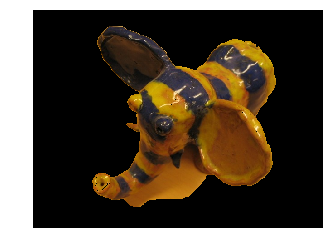

Mark background regions with left mouse button 

Press '0' or '1' for marking background or foreground, respectively, and again press 'n'
foreground pixels: 95065, background pixels: 212137


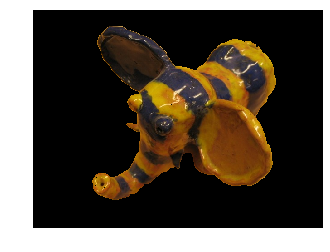

In [14]:
perform_grabcut("./data/images/ceramic.jpg", "./data/bboxes/ceramic.txt")

Draw a rectangle around the object using left mouse button 

Beta: 0.003966581463291084
Draw a rectangle on the image
Now press the key 'n' a few times until no further change

Press '0' or '1' for marking background or foreground, respectively, and again press 'n'
foreground pixels: 105117, background pixels: 202085


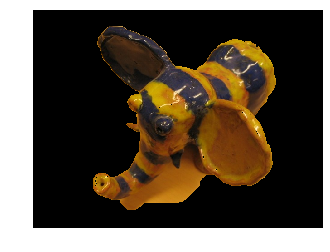

Mark background regions with left mouse button 

Press '0' or '1' for marking background or foreground, respectively, and again press 'n'
foreground pixels: 94973, background pixels: 212229


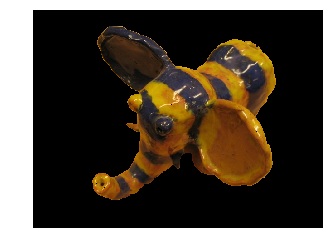

In [6]:
perform_grabcut("./data/images/ceramic.jpg")